In [18]:
from utils import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import asyncio
from sklearn.datasets import make_sparse_spd_matrix
import json
from solvers import *
import plotly.express as px
import pandas as pd

%matplotlib inline

In [19]:
def score(true, pred):
    p = pred.edges
    t = true.edges
    full = nx.complete_graph(len(true.nodes)).edges
    
    TP = len(p & t)
    TN = len((full - p) & (full - t))
    FP = len(p & (full - t))
    FN = len((full - p) & t)
    
    TPR = TP / (TP + FN) if TP + FN != 0 else np.nan
    FDR = FP / (FP + TP) if FP + TP != 0 else np.nan
    
    precision = 1 - FDR
    
    F1 = 2 * (precision * TPR) / (precision + TPR) if precision + TPR != 0 else np.nan
    
    return TPR, FDR, F1, FP, FN

# Рисунок 1 (Choletsky)
Зависимость параметра $\alpha$ от средней плотности графа.

In [57]:
S_exp = 1000
exp1_results = {20: [], 100: []}
alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [58]:
def alpha_experiment(dim, alpha):
    exp_densities = []
    for _ in range(S_exp):
        prec = make_sparse_spd_matrix(dim, alpha=alpha, norm_diag=True)
        density = sym_mat_density(prec)
        exp_densities.append(density)
        
    return exp_densities

In [59]:
for dim in exp1_results:
    for alpha in alphas:
        result = alpha_experiment(dim, alpha)
        exp1_results[dim].append(np.mean(result))
        
        print(f'Dimension: {dim}, alpha: {alpha}, mean density: {np.mean(result)}, std density: {np.std(result)}')

Dimension: 20, alpha: 0, mean density: 1.0, std density: 0.0
Dimension: 20, alpha: 0.1, mean density: 0.988363157894737, std density: 0.009201467725871193
Dimension: 20, alpha: 0.2, mean density: 0.970121052631579, std density: 0.016778391822012136
Dimension: 20, alpha: 0.3, mean density: 0.941136842105263, std density: 0.02727623340175945
Dimension: 20, alpha: 0.4, mean density: 0.8993157894736842, std density: 0.03859409482193687
Dimension: 20, alpha: 0.5, mean density: 0.8304578947368421, std density: 0.05313121555622451
Dimension: 20, alpha: 0.6, mean density: 0.7256368421052632, std density: 0.06462299767307958
Dimension: 20, alpha: 0.7, mean density: 0.5686052631578947, std density: 0.07461290223584258
Dimension: 20, alpha: 0.8, mean density: 0.3642578947368421, std density: 0.06838851837833146
Dimension: 20, alpha: 0.9, mean density: 0.15296315789473683, std density: 0.0460786485908135
Dimension: 20, alpha: 1, mean density: 0.0, std density: 0.0
Dimension: 100, alpha: 0, mean de

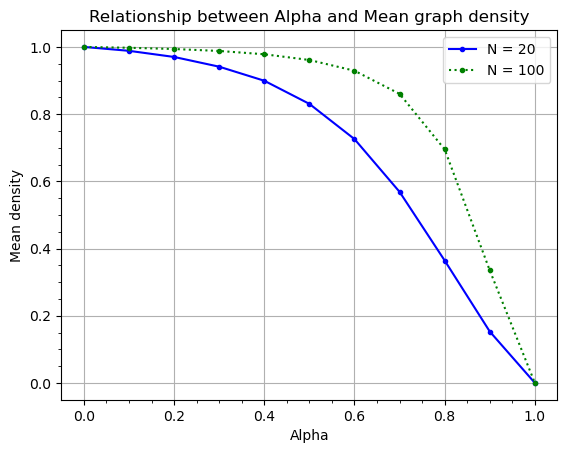

In [60]:
plt.plot(alphas, exp1_results[20], '.-b', label='N = 20')
plt.plot(alphas, exp1_results[100], '.:g', label='N = 100')
plt.title('Relationship between Alpha and Mean graph density')
plt.grid(True)
plt.minorticks_on()
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("Mean density")
plt.show()

In [62]:
with open('Chol_gen_GM_density_data.json', 'w') as f:
    json.dump(exp1_results, f)

# Рисунок 2 (Choletsky)
Гистограмма распределения значений генератора для N = 20 и плотности 0.9

In [223]:
mat = make_sparse_spd_matrix(20, alpha=0.4, norm_diag=True)
sym_mat_density(mat)

0.9

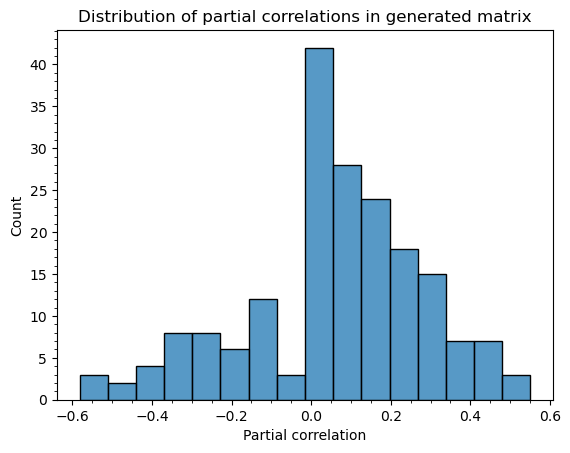

In [225]:
sns.histplot(mat[np.triu_indices_from(mat, k=1)])
plt.title('Distribution of partial correlations in generated matrix')
plt.xlabel('Partial correlation')
plt.minorticks_on()

# Рисунок 3 (Choletsky)
Гистограмма распределения значений генератора для N = 100 и плотности 0.9

In [79]:
mat = make_sparse_spd_matrix(100, alpha=0.65, norm_diag=True)
sym_mat_density(mat)

0.9006060606060606

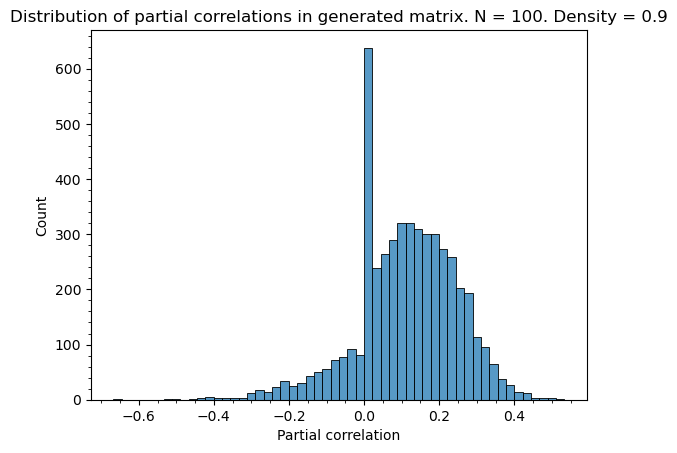

In [80]:
mat = make_sparse_spd_matrix(100, alpha=0.65, norm_diag=True)
sym_mat_density(mat)
sns.histplot(mat[np.triu_indices_from(mat, k=1)])
plt.title('Distribution of partial correlations in generated matrix. N = 100. Density = 0.9')
plt.xlabel('Partial correlation')
plt.minorticks_on()

# Рисунок 4, 5, 6 (Choletsky)

In [58]:
N = 20
n = 400
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
chol_alphas_20 = [0.94, 0.87, 0.85, 0.77, 0.74, 0.68, 0.64, 0.55, 0.4]
S_exp = 100
S_obs = 10
solvers = [MHT(adjustment=None), MHT(adjustment='sidak'), MHT(adjustment='holm'), MHT(adjustment='benjamini-hochberg')]

progress_count = 0

In [59]:
all_results_TPR = {solver.name: [] for solver in solvers}
all_results_FDR = {solver.name: [] for solver in solvers}
all_results_F1 = {solver.name: [] for solver in solvers}

for chol_alpha in tqdm(chol_alphas_20):
    exp_results_TPR = {solver.name: [] for solver in solvers}
    exp_results_FDR = {solver.name: [] for solver in solvers}
    exp_results_F1 = {solver.name: [] for solver in solvers}
    for exp_num in range(S_exp):
        precision = make_sparse_spd_matrix(N, alpha=chol_alpha)
        cov = np.linalg.inv(precision)
        graph = nx.from_numpy_array((precision != 0).astype(int) - np.eye(N))
        obs_results_TPR = {solver.name: [] for solver in solvers}
        obs_results_FDR = {solver.name: [] for solver in solvers}
        obs_results_F1 = {solver.name: [] for solver in solvers}
        
        for _ in range(S_obs):
            samples = np.random.multivariate_normal(np.zeros(N), cov, size=n)
            solver_results_TPR = {solver.name: [] for solver in solvers}
            solver_results_FDR = {solver.name: [] for solver in solvers}
            solver_results_F1 = {solver.name: [] for solver in solvers}
            for solver in solvers:
                solver.fit(samples)
                tpr, fdr, f1, fp, fn = score(graph, solver.cgraph)
                solver_results_TPR[solver.name].append(tpr)
                solver_results_FDR[solver.name].append(fdr)
                solver_results_F1[solver.name].append(f1)
            
            for solver in solvers:    
                obs_results_TPR[solver.name].append(np.nanmean(solver_results_TPR[solver.name]))
                obs_results_FDR[solver.name].append(np.nanmean(solver_results_FDR[solver.name]))
                obs_results_F1[solver.name].append(np.nanmean(solver_results_F1[solver.name]))
        
        for solver in solvers:    
            exp_results_TPR[solver.name].append(np.nanmean(obs_results_TPR[solver.name]))
            exp_results_FDR[solver.name].append(np.nanmean(obs_results_FDR[solver.name]))
            exp_results_F1[solver.name].append(np.nanmean(obs_results_F1[solver.name]))
    
    for solver in solvers:    
        all_results_TPR[solver.name].append(np.nanmean(exp_results_TPR[solver.name]))
        all_results_FDR[solver.name].append(np.nanmean(exp_results_FDR[solver.name]))
        all_results_F1[solver.name].append(np.nanmean(exp_results_F1[solver.name]))

100%|██████████| 9/9 [18:09<00:00, 121.03s/it]


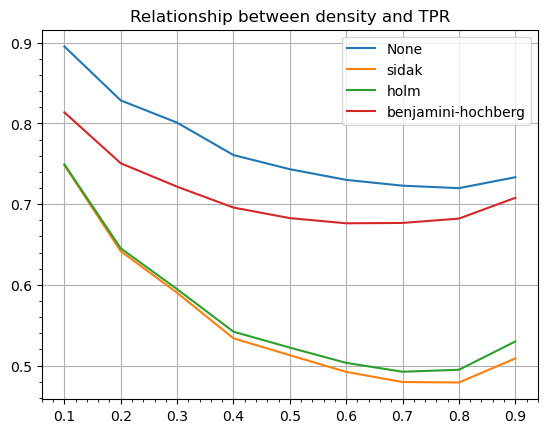

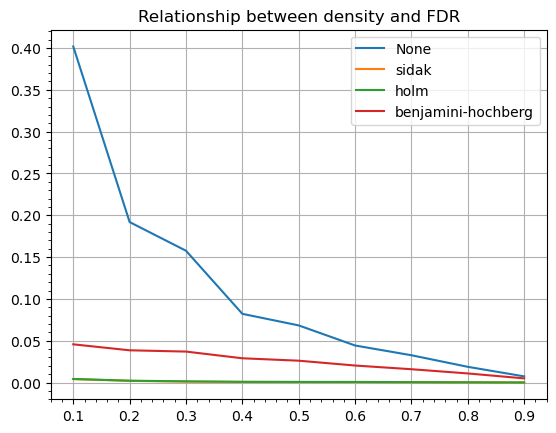

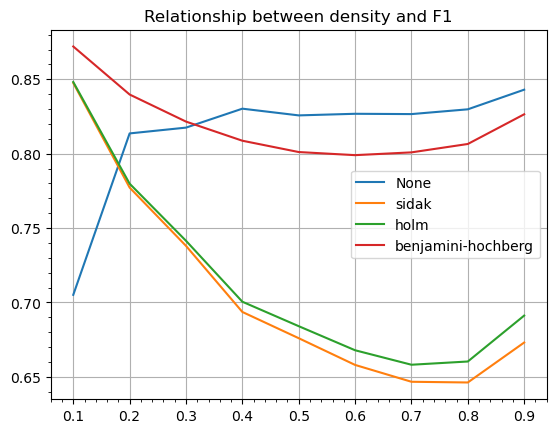

In [63]:
plt.title('Relationship between density and TPR')

for solver in solvers:
    plt.plot(alphas, all_results_TPR[solver.name], label=solver.name)
    
plt.legend()
plt.minorticks_on()
plt.grid(True)
plt.show()
plt.title('Relationship between density and FDR')

for solver in solvers:
    plt.plot(alphas, all_results_FDR[solver.name], label=solver.name)
    
plt.legend()
plt.minorticks_on()
plt.grid(True)
plt.show()
plt.title('Relationship between density and F1')

for solver in solvers:
    plt.plot(alphas, all_results_F1[solver.name], label=solver.name)
    
plt.legend()
plt.minorticks_on()
plt.grid(True)
plt.show()

In [51]:
solvers = [MHT(adjustment=None), MHT(adjustment='bonferroni'), MHT(adjustment='holm'), MHT(adjustment='benjamini-hochberg')]
deltas = [0.2]
n = 40
S_obs = 200

In [52]:
dfs = []

for delta in deltas:
    precision = np.diag([delta for i in range(19)], 1) + np.diag([delta for i in range(19)], -1) + np.eye(20)
    cov = np.linalg.inv(precision)
    graph = nx.from_numpy_array((precision != 0).astype(int) - np.eye(20))
    TPR_l = {solver.name: [] for solver in solvers}
    FDR_l = {solver.name: [] for solver in solvers}
    F1_l = {solver.name: [] for solver in solvers}
    FP_l = {solver.name: [] for solver in solvers}
    FN_l = {solver.name: [] for solver in solvers}
    for _ in range(S_obs):
        samples = np.random.multivariate_normal(np.zeros(20), cov, size=n)
        for solver in solvers:
            solver.fit(samples)
            tpr, fdr, f1, fp, fn = score(graph, solver.cgraph)
            TPR_l[solver.name].append(tpr)
            FDR_l[solver.name].append(fdr)
            F1_l[solver.name].append(f1)
            FP_l[solver.name].append(fp)
            FN_l[solver.name].append(fn)
            
    print(f'=== DELTA {delta} ===')
    table = []
    for solver in solvers:
        print(f'Algo: {solver.name} :: TPR = {np.around(np.nanmean(TPR_l[solver.name]), 2)}, FDR = {np.around(np.nanmean(FDR_l[solver.name]), 2)}, F1 = {np.around(np.nanmean(F1_l[solver.name]), 2)}')
        table.append([solver.name, np.around(np.nanmean(TPR_l[solver.name]), 2),
                      np.around(np.nanmean(FDR_l[solver.name]), 2),
                      np.around(np.nanmean(F1_l[solver.name]), 2),
                      np.mean(FP_l[solver.name]), np.mean(FN_l[solver.name])])
    
    dfs.append(pd.DataFrame(table, columns=['Algo', 'TPR', 'FDR', 'F1', 'FP', 'FN']))
    
    print()
    
        

=== DELTA 0.2 ===
Algo: None :: TPR = 0.14, FDR = 0.71, F1 = 0.19
Algo: bonferroni :: TPR = 0.0, FDR = 0.6, F1 = 0.1
Algo: holm :: TPR = 0.0, FDR = 0.6, F1 = 0.1
Algo: benjamini-hochberg :: TPR = 0.02, FDR = 0.6, F1 = 0.1



In [53]:
dfs[0]

,Algo,TPR,FDR,F1,FP,FN
0,None,0.14,0.71,0.19,7.730,16.310
1,bonferroni,0.00,0.60,0.10,0.040,18.975
2,holm,0.00,0.60,0.10,0.040,18.975
3,benjamini-hochberg,0.02,0.60,0.10,0.675,18.585


In [47]:
dfs[0]

,Algo,TPR,FDR,F1,FP,FN
0,None,1.0,0.30,0.82,8.640,0.000
1,bonferroni,1.0,0.00,1.00,0.045,0.005
2,holm,1.0,0.00,1.00,0.050,0.005
3,benjamini-hochberg,1.0,0.05,0.97,1.025,0.000


In [50]:
dfs[0]

,Algo,TPR,FDR,F1,FP,FN
0,None,0.69,0.35,0.66,8.445,5.895
1,bonferroni,0.08,0.01,0.19,0.040,17.450
2,holm,0.08,0.01,0.19,0.040,17.435
3,benjamini-hochberg,0.18,0.04,0.28,0.295,15.640


In [36]:
dfs[0]

,Algo,TPR,FDR,F1
0,None,0.68,0.35,0.66
1,bonferroni,0.08,0.02,0.19
2,holm,0.09,0.02,0.19
3,benjamini-hochberg,0.20,0.05,0.30


# n = 100

In [199]:
dfs[0] # delta = 0.5

,Algo,TPR,FDR,F1
0,None,1.00,0.29,0.82
1,sidak,0.89,0.00,0.94
2,holm,0.89,0.00,0.94
3,benjamini-hochberg,0.95,0.02,0.96
4,Graphical Lasso,0.90,0.56,0.59


In [200]:
dfs[1] # delta = 0.3

,Algo,TPR,FDR,F1
0,None,0.80,0.35,0.71
1,sidak,0.18,0.01,0.29
2,holm,0.18,0.01,0.29
3,benjamini-hochberg,0.32,0.04,0.47
4,Graphical Lasso,0.95,0.41,0.72


In [201]:
dfs[2] # delta = 0.2

,Algo,TPR,FDR,F1
0,None,0.43,0.50,0.45
1,sidak,0.03,0.14,0.13
2,holm,0.03,0.14,0.13
3,benjamini-hochberg,0.02,0.13,0.15
4,Graphical Lasso,0.47,0.41,0.50


In [202]:
dfs[3] # delta = 0.1

,Algo,TPR,FDR,F1
0,None,0.15,0.75,0.19
1,sidak,0.00,0.47,0.10
2,holm,0.00,0.47,0.10
3,benjamini-hochberg,0.00,0.33,0.10
4,Graphical Lasso,0.06,0.59,0.18


In [203]:
dfs[4] # delta = 0.05 

,Algo,TPR,FDR,F1
0,None,0.08,0.86,0.13
1,sidak,0.00,0.62,0.10
2,holm,0.00,0.62,0.10
3,benjamini-hochberg,0.00,1.00,NaN
4,Graphical Lasso,0.01,0.85,0.12


In [207]:
dfs[0] # delta = 0.5

,Algo,TPR,FDR,F1
0,None,1.00,0.29,0.82
1,sidak,1.00,0.00,1.00
2,holm,1.00,0.00,1.00
3,benjamini-hochberg,0.98,0.02,0.98
4,Graphical Lasso,0.90,0.55,0.60


In [208]:
dfs[1] # delta = 0.3

,Algo,TPR,FDR,F1
0,None,1.00,0.30,0.82
1,sidak,0.95,0.00,0.97
2,holm,0.95,0.00,0.97
3,benjamini-hochberg,0.96,0.02,0.97
4,Graphical Lasso,1.00,0.22,0.87


In [209]:
dfs[2] # delta = 0.2

,Algo,TPR,FDR,F1
0,None,0.92,0.32,0.78
1,sidak,0.38,0.01,0.54
2,holm,0.38,0.01,0.54
3,benjamini-hochberg,0.62,0.04,0.75
4,Graphical Lasso,0.92,0.22,0.84


In [210]:
dfs[3] # delta = 0.1

,Algo,TPR,FDR,F1
0,None,0.38,0.53,0.42
1,sidak,0.03,0.11,0.12
2,holm,0.02,0.11,0.12
3,benjamini-hochberg,0.02,0.14,0.16
4,Graphical Lasso,0.17,0.27,0.30


In [211]:
dfs[4] # delta = 0.05

,Algo,TPR,FDR,F1
0,None,0.12,0.78,0.17
1,sidak,0.00,0.64,0.10
2,holm,0.00,0.62,0.10
3,benjamini-hochberg,0.00,0.30,0.10
4,Graphical Lasso,0.01,0.62,0.13


In [10]:
precision = np.diag([0.5 for i in range(4)], 1) + np.diag([0.5 for i in range(4)], -1) + np.eye(5)
cov = np.linalg.inv(precision)
graph = nx.from_numpy_array((precision != 0).astype(int) - np.eye(5))

samples = np.random.multivariate_normal(np.zeros(5), cov, size=1000)

solver = MHT(adjustment='benjamini-hochberg')

solver.fit(samples)

score(graph, solver.cgraph)

(1.0, 0.0, 1.0)

In [32]:
from sklearn.covariance import GraphicalLasso

GraphicalLasso()

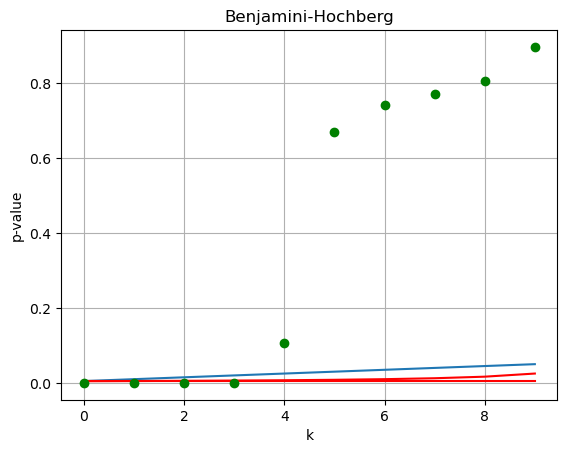

array([0., 0., 0., 0.])

In [16]:
p = test_graph(solver.part, solver.n)
m = 10
ks = np.arange(10)
psort = np.sort(p[np.triu_indices_from(p, k=1)])
line = (ks+1) / 10 * 0.05
line_bonf = [0.05 / 10 for k in ks]
line_holm = [0.05 / (m +  1 - k) for k in ks]
plt.plot(ks, line)
plt.plot(ks, line_bonf, 'g')
plt.plot(ks, line_holm, 'r')
plt.plot(ks, psort, 'og')
plt.title('Benjamini-Hochberg')
plt.grid(True)
plt.ylabel('p-value')
plt.xlabel('k')
plt.show()
psort[psort < line]

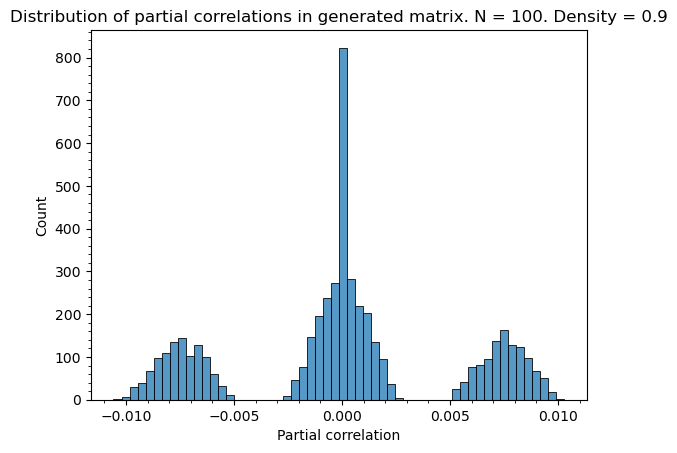

In [72]:
mat = generate_peng(100, 0.9)
mat = mat[0]
sns.histplot(mat[np.triu_indices_from(mat, k=1)])
plt.title('Distribution of partial correlations in generated matrix. N = 100. Density = 0.9')
plt.xlabel('Partial correlation')
plt.minorticks_on()